In [97]:
import openai
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch

import matplotlib.pyplot as plt
import secrets

openai.api_key = "our api_key"  

In [4]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model
    )
    return response.data[0].embedding

In [5]:
# Load historical and new data
df_1 = pd.read_csv("gss_with_llm_responses_1.csv")
df_2 = pd.read_csv("gss_with_llm_responses_2.csv")
df_3 = pd.read_csv("gss_with_llm_responses_3.csv")
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
df.rename(columns={
    'Average_Human': 'Average_Human_Response',
    'Average_LLM_response': 'Average_LLM_Response'
}, inplace=True)

# Delet missing data
df = df[df['Average_Human_Response'].notna()]
df.reset_index(drop=True, inplace=True)

# Add embedding
tqdm.pandas()
df["Embedding"] = df["Question"].progress_apply(get_embedding)

# Save to new CSVs with embeddings
df.to_pickle("survey_with_embeddings.pkl")  # Use pickle to keep list structure

100%|██████████| 112/112 [00:28<00:00,  3.87it/s]


In [72]:
def fit_beta(df, lambda_ridge=1.0):
    """
    Fit ridge and compute train MSE of the debiased responses.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns
          - 'Embedding'  : array‐like of length d
          - 'Average_LLM_Response'
          - 'Average_Human_Response'
    """
    
    # stack embeddings into X (n × d)
    X = np.vstack(df["Embedding"].values)             # shape (n, d)
    # the "bias" target y = LLM − Human
    y_bias = (df["Average_LLM_Response"] 
              - df["Average_Human_Response"]).to_numpy()  # shape (n,)

    # fit ridge WITHOUT intercept
    model = Ridge(alpha=lambda_ridge, fit_intercept=False)
    model.fit(X, y_bias)
    beta_hat = model.coef_                             # shape (d,)

    # compute debiased response on train
    df["Debiased_Response"] = df["Average_LLM_Response"].to_numpy() - X.dot(beta_hat)

    # compute train‐set MSE against the true human response
    mse_train = np.mean((df["Debiased_Response"] - df["Average_Human_Response"].to_numpy())**2)

    return beta_hat, mse_train


def fit_beta_pca(df, n_components: int = 50):
    """
    1) PCA-reduce the 'Embedding' to n_components,
    2) regress (LLM − Human) on those PCs via OLS (no intercept),
    3) compute Debiased_Response = LLM − X_pca @ beta,
    4) return beta, train MSE, and the fitted PCA model.

    Side-effect: adds df['Debiased_Response'].
    """
    # stack into matrix
    X_orig = np.vstack(df["Embedding"].values)               # (n, d_orig)
    y_bias = (df["Average_LLM_Response"] 
              - df["Average_Human_Response"]).to_numpy()    # (n,)

    # PCA
    pca = PCA(n_components=n_components, random_state=0)
    X_pca = pca.fit_transform(X_orig)                        # (n, n_components)

    # OLS (no intercept)
    ols = LinearRegression(fit_intercept=False)
    ols.fit(X_pca, y_bias)
    beta_hat = ols.coef_                                     # (n_components,)

    # debiased response + MSE
    df["Debiased_Response"] = df["Average_LLM_Response"].to_numpy() - X_pca.dot(beta_hat)
    mse_train = np.mean((df["Debiased_Response"] - df["Average_Human_Response"].to_numpy())**2)

    return beta_hat, mse_train, pca


def fit_beta_factor(df, n_components: int = 50):
    """
    Same as fit_beta_pca but uses FactorAnalysis instead of PCA;
    returns beta, train MSE, and the fitted FA model.
    """
    # stack into matrix
    X_orig = np.vstack(df["Embedding"].values)
    y_bias = (df["Average_LLM_Response"] 
              - df["Average_Human_Response"]).to_numpy()

    # Factor Analysis
    fa = FactorAnalysis(n_components=n_components, random_state=0)
    X_fa = fa.fit_transform(X_orig)                          # (n, n_components)

    # OLS (no intercept)
    ols = LinearRegression(fit_intercept=False)
    ols.fit(X_fa, y_bias)
    beta_hat = ols.coef_

    # debiased response + MSE
    df["Debiased_Response"] = df["Average_LLM_Response"].to_numpy() - X_fa.dot(beta_hat)
    mse_train = np.mean((df["Debiased_Response"] - df["Average_Human_Response"].to_numpy())**2)

    return beta_hat, mse_train, fa

In [73]:
def fit_beta_pca_penalty(
    df,
    n_components: int = 50,
    penalty_coef: float = 1.0,
    lr: float = 1e-2,
    epochs: int = 200,
):
    """
    PCA → penalized-OLS via GD:
      loss = MSE(debiased,human) + penalty_coef * mean(|y - pred| * I(y*pred<0))
    Returns:
      beta_hat (n_components,), mse_train, and fitted PCA.
    Side‐effect: df['Debiased_Response'] is added.
    """
    # 1) assemble data
    X_orig = np.vstack(df["Embedding"].values)                # (n, D)
    llm   = df["Average_LLM_Response"].to_numpy()             # (n,)
    human = df["Average_Human_Response"].to_numpy()           # (n,)
    y = llm - human                                           # true bias

    # 2) reduce
    pca = PCA(n_components=n_components, random_state=0)
    X = pca.fit_transform(X_orig)                             # (n, k)

    # 3) torch tensors
    X_t     =   torch.from_numpy(X).float()                   # (n,k)
    y_t     =   torch.from_numpy(y).float()                   # (n,)
    llm_t   =   torch.from_numpy(llm).float()                 # (n,)
    human_t =   torch.from_numpy(human).float()               # (n,)

    # 4) params + optimizer
    beta = torch.zeros(n_components, requires_grad=True)
    opt  = torch.optim.Adam([beta], lr=lr)

    # 5) GD loop
    for _ in range(epochs):
        pred = X_t @ beta                                     # (n,)
        debiased = llm_t - pred                               # (n,)

        # MSE loss
        mse_loss = torch.mean((debiased - human_t)**2)

        # sign‐mismatch penalty
        mask = (y_t * pred < 0).float()                       # 1 if wrong sign
        pen  = torch.mean(mask * torch.abs(y_t - pred))

        loss = mse_loss + penalty_coef * pen

        opt.zero_grad()
        loss.backward()
        opt.step()

    # 6) finalize
    beta_hat = beta.detach().numpy()                          # (k,)
    df["Debiased_Response"] = llm - X.dot(beta_hat)
    mse_train = np.mean((df["Debiased_Response"] - human)**2)

    return beta_hat, mse_train, pca


def fit_beta_factor_penalty(
    df,
    n_components: int = 50,
    penalty_coef: float = 1.0,
    lr: float = 1e-2,
    epochs: int = 200,
):
    """
    Same as fit_beta_pca but uses FactorAnalysis instead of PCA.
    Returns beta_hat, mse_train, and fitted FA.
    """
    X_orig = np.vstack(df["Embedding"].values)
    llm   = df["Average_LLM_Response"].to_numpy()
    human = df["Average_Human_Response"].to_numpy()
    y     = llm - human

    fa = FactorAnalysis(n_components=n_components, random_state=0)
    X = fa.fit_transform(X_orig)                              # (n, k)

    X_t     = torch.from_numpy(X).float()
    y_t     = torch.from_numpy(y).float()
    llm_t   = torch.from_numpy(llm).float()
    human_t = torch.from_numpy(human).float()

    beta = torch.zeros(n_components, requires_grad=True)
    opt  = torch.optim.Adam([beta], lr=lr)

    for _ in range(epochs):
        pred = X_t @ beta
        debiased = llm_t - pred

        mse_loss = torch.mean((debiased - human_t)**2)
        mask     = (y_t * pred < 0).float()
        pen      = torch.mean(mask * torch.abs(y_t - pred))
        loss     = mse_loss + penalty_coef * pen

        opt.zero_grad()
        loss.backward()
        opt.step()

    beta_hat = beta.detach().numpy()
    df["Debiased_Response"] = llm - X.dot(beta_hat)
    mse_train = np.mean((df["Debiased_Response"] - human)**2)

    return beta_hat, mse_train, fa


Run Experiement

In [103]:
# Load the pickle file (with embeddings as lists)
df = pd.read_pickle("survey_with_embeddings.pkl")

# this will randomly select 100 rows for train, and the other 12 for valid
train_df, valid_df = train_test_split(
    df,
    train_size=100,
    random_state=8566,   # for reproducibility
    shuffle=True
)
print(train_df.shape)  # (100, )
print(valid_df.shape)  # (12, )
print("Embedding shape:", len(df["Embedding"].iloc[0]))

# your list of regularization strengths
lambdas = [0.01, 0.1, 1.0, 5.0, 10.0]

# a place to collect (lambda, mse, beta) tuples
results = []

for lam in lambdas:
    # fit on a fresh copy so we don't overwrite Debiased_Response repeatedly
    beta_hat, mse_train = fit_beta(train_df.copy(), lambda_ridge=lam)
    
    # print out for quick console feedback
    print(f"λ={lam:>5} → train MSE = {mse_train:.4f}")
    
    # record into our list
    results.append({
        "lambda":        lam,
        "mse_train":     mse_train,
        "beta_hat":      beta_hat  # this is a length-d numpy array
    })

(100, 5)
(12, 5)
Embedding shape: 1536
λ= 0.01 → train MSE = 0.0049
λ=  0.1 → train MSE = 0.0861
λ=  1.0 → train MSE = 0.4322
λ=  5.0 → train MSE = 0.7099
λ= 10.0 → train MSE = 0.7904


In [116]:
# get embeddings matrix on valid
X_val = np.vstack(valid_df["Embedding"].values)
# raw llm
y_llm = valid_df["Average_LLM_Response"].to_numpy()
# corrected
valid_df["Debiased_Response"] = y_llm - X_val.dot(results[3]['beta_hat'])

# evaluate on valid
mse_valid = np.mean((valid_df["Debiased_Response"] - valid_df["Average_Human_Response"].to_numpy())**2)
print("Validation MSE:", mse_valid)
# list the row‐indices you want to keep
keep_idx = [35, 2, 8, 43, 22, 18, 70, 12, 17, 82]

# select them directly from valid_df
selected_df = valid_df.loc[keep_idx].reset_index(drop=True)
selected_df.head(10)

Validation MSE: 0.22868321909503128


,Variable_Name,Average_Human_Response,Question,Average_LLM_Response,Embedding,Debiased_Response
0,abfirm,3.428571,How firm are you about your opinion on abortio...,4.000000,"[0.0027009211480617523, -0.004779394716024399,...",4.026930
1,natchld,1.496186,We are faced with many problems in this countr...,1.166667,"[0.032813724130392075, -0.015181060880422592, ...",1.457039
2,lawimp,1.716904,How important is the law enforcement issue to ...,2.000000,"[0.005202507134526968, -0.008557395078241825, ...",2.083203
3,marhisp,2.643818,What about having a close relative marry a Jew...,2.666667,"[-0.011182423681020737, 0.007882031612098217, ...",2.823690
4,conbus,1.934551,I am going to name some institutions in this c...,2.000000,"[0.03869510814547539, -0.029890233650803566, 0...",2.070480
5,life,1.587822,"In general, do you find life exciting, pretty ...",1.000000,"[-0.012269247323274612, -0.015354420989751816,...",1.017410
6,letineur,3.398006,What about the number of immigrants from Europ...,3.000000,"[-0.022011730819940567, 0.00751867052167654, 0...",3.284984
7,alienat1,1.465340,Now I want to read you some things some people...,1.166667,"[0.023283887654542923, 0.01102173700928688, -0...",1.270408
8,hapcohab,1.458306,"Taking things all together, would you say that...",1.000000,"[-0.008415235206484795, -0.058157648891210556,...",1.016566
9,conclerg,1.964817,I am going to name some institutions in this c...,2.000000,"[0.023766914382576942, -0.022856036201119423, ...",2.096062


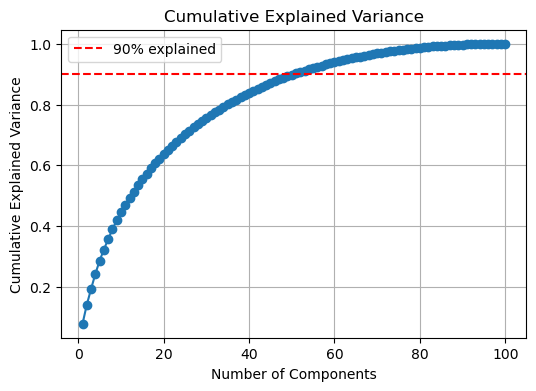

In [105]:
# 1) Stack your training embeddings into an (N × D) matrix
X_train = np.vstack(train_df["Embedding"].values)   # shape: (100, D)

# 2) Fit an “untruncated” PCA to get all eigenvalues
pca_full = PCA(random_state=0)
pca_full.fit(X_train)

# 3) Extract the raw eigenvalues (not the explained-variance ratios)
eigenvalues = pca_full.explained_variance_          # length = min(N,D)

# 4) Cumulative explained variance
cum_ev = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(
    np.arange(1, len(cum_ev)+1),
    cum_ev,
    marker='o', linestyle='-'
)
plt.axhline(0.90, color='r', linestyle='--', label='90% explained')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

In [117]:
# PCA‐based
beta_pca, mse_pca, pca_model = fit_beta_pca_penalty(train_df.copy(), n_components=50, penalty_coef=20.0)
Xv = pca_model.transform(np.vstack(valid_df["Embedding"].values))
valid_df["Debiased_Response"] = valid_df["Average_LLM_Response"].to_numpy() - Xv.dot(beta_pca)
mse_val_pca = np.mean((valid_df["Debiased_Response"] - valid_df["Average_Human_Response"].to_numpy())**2)
print("Valid MSE (PCA):", mse_val_pca)
selected_df = valid_df.loc[keep_idx].reset_index(drop=True)
selected_df.head(10)

Valid MSE (PCA): 0.1508865787637614


,Variable_Name,Average_Human_Response,Question,Average_LLM_Response,Embedding,Debiased_Response
0,abfirm,3.428571,How firm are you about your opinion on abortio...,4.000000,"[0.0027009211480617523, -0.004779394716024399,...",3.705255
1,natchld,1.496186,We are faced with many problems in this countr...,1.166667,"[0.032813724130392075, -0.015181060880422592, ...",1.237994
2,lawimp,1.716904,How important is the law enforcement issue to ...,2.000000,"[0.005202507134526968, -0.008557395078241825, ...",1.723790
3,marhisp,2.643818,What about having a close relative marry a Jew...,2.666667,"[-0.011182423681020737, 0.007882031612098217, ...",2.503659
4,conbus,1.934551,I am going to name some institutions in this c...,2.000000,"[0.03869510814547539, -0.029890233650803566, 0...",1.928694
5,life,1.587822,"In general, do you find life exciting, pretty ...",1.000000,"[-0.012269247323274612, -0.015354420989751816,...",1.139519
6,letineur,3.398006,What about the number of immigrants from Europ...,3.000000,"[-0.022011730819940567, 0.00751867052167654, 0...",3.093710
7,alienat1,1.465340,Now I want to read you some things some people...,1.166667,"[0.023283887654542923, 0.01102173700928688, -0...",1.173483
8,hapcohab,1.458306,"Taking things all together, would you say that...",1.000000,"[-0.008415235206484795, -0.058157648891210556,...",1.058514
9,conclerg,1.964817,I am going to name some institutions in this c...,2.000000,"[0.023766914382576942, -0.022856036201119423, ...",2.045277


In [118]:
# FA‐based
beta_fa, mse_fa, fa_model = fit_beta_factor_penalty(train_df.copy(), n_components=50, penalty_coef=20.0)
Xv_fa = fa_model.transform(np.vstack(valid_df["Embedding"].values))
valid_df["Debiased_Response"] = valid_df["Average_LLM_Response"].to_numpy() - Xv_fa.dot(beta_fa)
mse_val_fa = np.mean((valid_df["Debiased_Response"] - valid_df["Average_Human_Response"].to_numpy())**2)
print("Valid MSE (FA):", mse_val_fa)
selected_df = valid_df.loc[keep_idx].reset_index(drop=True)
selected_df.head(10)

Valid MSE (FA): 0.13708485034567763


,Variable_Name,Average_Human_Response,Question,Average_LLM_Response,Embedding,Debiased_Response
0,abfirm,3.428571,How firm are you about your opinion on abortio...,4.000000,"[0.0027009211480617523, -0.004779394716024399,...",3.419069
1,natchld,1.496186,We are faced with many problems in this countr...,1.166667,"[0.032813724130392075, -0.015181060880422592, ...",1.225269
2,lawimp,1.716904,How important is the law enforcement issue to ...,2.000000,"[0.005202507134526968, -0.008557395078241825, ...",1.460936
3,marhisp,2.643818,What about having a close relative marry a Jew...,2.666667,"[-0.011182423681020737, 0.007882031612098217, ...",2.347552
4,conbus,1.934551,I am going to name some institutions in this c...,2.000000,"[0.03869510814547539, -0.029890233650803566, 0...",1.901836
5,life,1.587822,"In general, do you find life exciting, pretty ...",1.000000,"[-0.012269247323274612, -0.015354420989751816,...",1.316262
6,letineur,3.398006,What about the number of immigrants from Europ...,3.000000,"[-0.022011730819940567, 0.00751867052167654, 0...",3.164949
7,alienat1,1.465340,Now I want to read you some things some people...,1.166667,"[0.023283887654542923, 0.01102173700928688, -0...",1.340258
8,hapcohab,1.458306,"Taking things all together, would you say that...",1.000000,"[-0.008415235206484795, -0.058157648891210556,...",1.063389
9,conclerg,1.964817,I am going to name some institutions in this c...,2.000000,"[0.023766914382576942, -0.022856036201119423, ...",2.094103


In [101]:
# Load the pickle file (with embeddings as lists)
df = pd.read_pickle("survey_with_embeddings.pkl")

seeds = [secrets.randbelow(10000) for _ in range(50)]
for seed in seeds:
    print(seed)
    # this will randomly select 100 rows for train, and the other 12 for valid
    train_df, valid_df = train_test_split(
        df,
        train_size=100,
        random_state=seed,   # for reproducibility
        shuffle=True
    )
    # print(train_df.shape)  # (100, )
    # print(valid_df.shape)  # (12, )
    # print("Embedding shape:", len(df["Embedding"].iloc[0]))

    # your list of regularization strengths
    lambdas = [1.0, 5.0]

    # a place to collect (lambda, mse, beta) tuples
    results = []

    for lam in lambdas:
        # fit on a fresh copy so we don't overwrite Debiased_Response repeatedly
        beta_hat, mse_train = fit_beta(train_df.copy(), lambda_ridge=lam)
        
        # print out for quick console feedback
        # print(f"λ={lam:>5} → train MSE = {mse_train:.4f}")
        
        # record into our list
        results.append({
            "lambda":        lam,
            "mse_train":     mse_train,
            "beta_hat":      beta_hat  # this is a length-d numpy array
        })
        
    # get embeddings matrix on valid
    X_val = np.vstack(valid_df["Embedding"].values)
    # raw llm
    y_llm = valid_df["Average_LLM_Response"].to_numpy()
    # corrected
    valid_df["Debiased_Response"] = y_llm - X_val.dot(results[1]['beta_hat'])

    # evaluate on valid
    mse_valid = np.mean((valid_df["Debiased_Response"] - valid_df["Average_Human_Response"].to_numpy())**2)
    print("Validation MSE:", mse_valid)

    # PCA‐based
    beta_pca, mse_pca, pca_model = fit_beta_pca_penalty(train_df.copy(), n_components=50, penalty_coef=20.0)
    Xv = pca_model.transform(np.vstack(valid_df["Embedding"].values))
    valid_df["Debiased_Response"] = valid_df["Average_LLM_Response"].to_numpy() - Xv.dot(beta_pca)
    mse_val_pca = np.mean((valid_df["Debiased_Response"] - valid_df["Average_Human_Response"].to_numpy())**2)
    print("Valid MSE (PCA):", mse_val_pca)

    # FA‐based
    beta_fa, mse_fa, fa_model = fit_beta_factor_penalty(train_df.copy(), n_components=50, penalty_coef=50.0)
    Xv_fa = fa_model.transform(np.vstack(valid_df["Embedding"].values))
    valid_df["Debiased_Response"] = valid_df["Average_LLM_Response"].to_numpy() - Xv_fa.dot(beta_fa)
    mse_val_fa = np.mean((valid_df["Debiased_Response"] - valid_df["Average_Human_Response"].to_numpy())**2)
    print("Valid MSE (FA):", mse_val_fa)

4047
Validation MSE: 0.4351917695028266
Valid MSE (PCA): 0.5178581906379968
Valid MSE (FA): 0.4626747580751937
9415
Validation MSE: 1.256509586074197
Valid MSE (PCA): 1.2188123726385827
Valid MSE (FA): 0.9474821357016237
9624
Validation MSE: 0.6742240423011244
Valid MSE (PCA): 0.6342093579190974
Valid MSE (FA): 0.6481571288334861
8987
Validation MSE: 0.3638836335171227
Valid MSE (PCA): 0.504544099286027
Valid MSE (FA): 0.6871484707272929
1779
Validation MSE: 0.3618398442646787
Valid MSE (PCA): 0.30531722260762667
Valid MSE (FA): 0.48982789044708985
143
Validation MSE: 0.3805280657604546
Valid MSE (PCA): 0.44307956922521163
Valid MSE (FA): 0.4923142405502358
200
Validation MSE: 0.4567410142072303
Valid MSE (PCA): 0.6697417858323522
Valid MSE (FA): 0.9047628359537169
8932
Validation MSE: 0.6601207810940517
Valid MSE (PCA): 0.7289368554508209
Valid MSE (FA): 0.8844843204078109
6458
Validation MSE: 0.3090394962061997
Valid MSE (PCA): 0.3342332807241772
Valid MSE (FA): 0.43765360502555445
2

In [ ]:
## 9997 5235 8566